## Do albums reviewed as "Best New Music" have a consistent score threshold? In other words, is there a score beyond which an album is considered 'great'/'best' and is then added to their "Best New Music" page?



## Introduction

In order to run our Hypothesis Testing Analysis, we will :
- [Make an Observation](#Observation)
- [Examine the Reseach](#Previous-Research)
- [Form a Hypothesis](#Hypothesis-Formulation)
- [Conduct an Experiment](#Experiment)
- [Analyse Experimental Results](#Analysis)
- [Draw Conclusions](#Conclusions)

## Observation

Our intent here is to measure with confidence if an album is going to be labelled as "Dest New Music". We will be looking at any score threshold and the ratio Best Music Flag / high score. This flag has been introced in 2003 and is intended to let readers know that Pitchfork reviewer highly liked the album.

## Previous Research

As Pitchfork can make/break a group career, some people have already looked at the Pitchfork reviews data. Bellow a few links to existing studies:
* https://nolanbconaway.github.io/blog/2017/pitchfork-roundup
* https://nsgrantham.com/pitchfork-reviews/
* http://decibelsanddecimals.com/dbdblog/2015/8/30/does-pitchfork-inflate-grades.html
* http://decibelsanddecimals.com/dbdblog/2015/7/19/pitchfork-r.html

## Hypothesis Formulation

So going back to our observation, bellow are our Alternative Hypothesis and Null Hypothesis :

**Ha** : There is a significant scoring difference between "Best new music" flagged albums vs the rest.

**Ho** : There is no significant scoring difference between "Best new music" flagged albums vs the rest.


## Experiment

Our experiment have already been done by Nolan Conaway 2 years ago. He conduct the experiment by scraping over 18,000 Pitchfork reviews from 1999 to 2017. The detailed process is explained [source](https://www.kaggle.com/nolanbconaway/pitchfork-data) as well as the resulting sqlite reviews database. 
The dataset contains :

Table | Total Rows | Total Columns | Columns
--- | :- | :--- | :---:
artists | 18831 | 2 | reviewid, artist
content | 18393 | 2 | reviewid, content
genres | 22680 | 2 | reviewid, genre
labels | 20190 | 2 | reviewid, label
reviews | 18393 | 13 | reviewid, title, artist, url, score, best_new_music, author, author_type, pub_date, pub_weekday, pub_day, pub_month, pub_year
years | 19108 | 2 | reviewid, year


## Analysis


In [1]:
# Import necessary librairies
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import random


import seaborn as sns
sns.set(color_codes=True)

In [2]:
# Connect to Pitchfork database
conn = sqlite3.Connection('database.sqlite')
c = conn.cursor()

In [6]:
# Retrieve all reviews and initialise our reviews DataFrame
c.execute("""
SELECT *
FROM reviews
""")
reviews_df = pd.DataFrame(c.fetchall())
reviews_df.columns = [x[0] for x in c.description]
reviews_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [40]:
# Determine when "Best New Music" flag has been introduced
reviews_df[reviews_df['best_new_music'] == 1].sort_values(by='pub_date').head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
16410,6059,s.t.r.e.e.t. d.a.d.,out hud,http://pitchfork.com/reviews/albums/6059-stree...,9.0,1,eric carr,contributor,2003-01-15,2,15,1,2003
16404,187,everything is good here/please come home,the angels of light,http://pitchfork.com/reviews/albums/187-everyt...,8.6,1,dominique leone,contributor,2003-01-20,0,20,1,2003
16401,5267,mount eerie,the microphones,http://pitchfork.com/reviews/albums/5267-mount...,8.9,1,eric carr,contributor,2003-01-20,0,20,1,2003
16359,952,you forgot it in people,broken social scene,http://pitchfork.com/reviews/albums/952-you-fo...,9.2,1,ryan schreiber,editor-in-chief,2003-02-02,6,2,2,2003
16353,7314,do you party?,the soft pink truth,http://pitchfork.com/reviews/albums/7314-do-yo...,8.4,1,dominique leone,contributor,2003-02-04,1,4,2,2003


In [61]:
# Split the reviews in two category tagged or not tagged as "Best Music" and filter by
# Remove reviews prior 2013-01-15
best_new_music_df = reviews_df[reviews_df['best_new_music'] == 1]

not_best_music_df = reviews_df[reviews_df['best_new_music'] == 0][reviews_df['pub_date'] >= '2003-01-15']

/Users/francoisleralle/dev/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


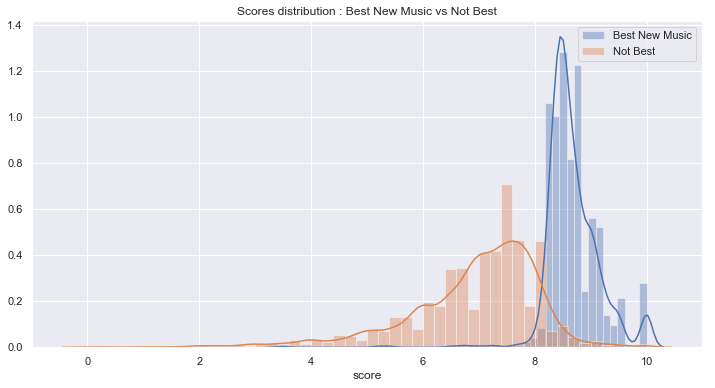

In [62]:
# Display scoring distribution Best New Music vs Not Best.
plt.figure(figsize=(12,6))
sns.distplot(best_new_music_df['score'], label='Best New Music')
sns.distplot(not_best_music_df['score'], label='Not Best')

plt.legend()
plt.title('Scores distribution : Best New Music vs Not Best');

In [63]:
### Effect size analysis
# Calculate simple overlap threshold
best_mean = best_new_music_df['score'].mean()
not_best_mean = not_best_music_df['score'].mean()
best_std = best_new_music_df['score'].std()
not_best_std = not_best_music_df['score'].std()

thresh = (best_mean*best_std + not_best_mean*not_best_std) / (best_std + not_best_std)
thresh

7.432698834204874

In [64]:
best_new_below_thresh = sum(best_new_music_df['score'] < thresh)
best_new_below_thresh

9

In [65]:
not_best_music_above_thresh = sum(not_best_music_df['score'] > thresh)
not_best_music_above_thresh

5820

In [66]:
# Calculate the overlap 
overlap = best_new_below_thresh / len(best_new_music_df) + not_best_music_above_thresh / len(not_best_music_df)
overlap

0.385731714514201

In [87]:
# Repeated randomness
np.random.seed(123)

def overlap_superiority_cohen_u3(group1, group2, n=1000):
    """Estimates overlap, superiority and Cohen U3 based on a sample.
    
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    n: sample size
    """

    # Get a sample of size n from both groups
    group1_sample = group1.sample(n)
    group2_sample = group2.sample(n)
    
    # Identify the threshold between samples
    thresh = (group1.mean() + group2.mean()) / 2
    
    # Calculate no. of values above and below for group 1 and group 2 respectively
    above = sum(group1_sample < thresh)
    below = sum(group2_sample > thresh)
    
    # Calculate the overlap
    overlap = (above + below) / n
    
    # Calculate probability of superiority
    superiority = sum(x > y for x, y in zip(group1_sample, group2_sample)) / n
    
    cohen_u3 = sum(x > group2_sample.mean() for x in group1_sample) / n

    return overlap, superiority, cohen_u3

distribution_min_len = min(len(best_new_music_df), len(not_best_music_df))
overlap_superiority(best_new_music_df['score'], not_best_music_df['score'], distribution_min_len)

(0.2682926829268293, 0.9501590668080594, 0.9936373276776246)

In [88]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

Cohen_d(best_new_music_df['score'], not_best_music_df['score'])

1.5013579305514908

In [89]:
# Conclusion: Cohen's d of 1.5 is quite significant, 99 % of the "Best New Music" group will be above the mean of the "Not Best" group (Cohen's U3),
# 26 % of the two groups will overlap, and there is a 95 % chance that a review picked at random from the "Best Music"
# group will have a higher score than a review picked at random from the "Not Best" group (probability of superiority).

### Exploring the reviewer with highest BNM ratio

In [189]:
# We saw previously that there is a significant difference between BNM (Best New Music) and the rest.
# Let's look at the ratio of BNM  per reviewer now

# Retrieve count/sum of BNM per reviewer
aggregations = {
    'best_new_music':{
        'bnm_count': 'sum',
        'review_count': 'count'
    }
}

authors_df = reviews_df[reviews_df['pub_date'] >= '2003-01-15'].groupby('author', as_index=False).agg(aggregations)
authors_df.columns = authors_df.columns.droplevel(level=0)
authors_df.columns = ['author', 'bnm_count', 'review_count']

# Add the BNM ratio column
authors_df['bnm_ratio'] = authors_df['bnm_count'] / authors_df['review_count']
authors_df.head()

/Users/francoisleralle/dev/anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,author,bnm_count,review_count,bnm_ratio
0,aaron leitko,4,97,0.041237
1,abby garnett,0,5,0.000000
2,abigail covington,0,2,0.000000
3,abigail garnett,0,4,0.000000
4,adam moerder,1,209,0.004785


In [190]:
# We can have a look at the most generous reviewer with more than a specific nb review threshold
authors_df.describe()

,bnm_count,review_count,bnm_ratio
count,373.000000,373.000000,373.000000
mean,2.528150,44.005362,0.051421
std,7.585526,95.816805,0.150577
min,0.000000,1.000000,0.000000
25%,0.000000,2.000000,0.000000
50%,0.000000,9.000000,0.000000
75%,1.000000,37.000000,0.041237
max,88.000000,725.000000,1.000000


In [218]:
# We can filter reviewer by their actual number of review > qt50
review_qt50 = authors_df['review_count'].quantile(.5)
filtered_authors_df = authors_df[authors_df['review_count'] >= review_qt50]
filtered_authors_df.sort_values('bnm_ratio', ascending=False)

,author,bnm_count,review_count,bnm_ratio
315,ryan schreiber,7,12,0.583333
196,kris ex,7,15,0.466667
347,stephen thomas erlewine,4,11,0.363636
30,anupa mistry,5,14,0.357143
152,jeff weiss,5,16,0.312500
153,jenn pelly,11,41,0.268293
163,jillian mapes,4,15,0.266667
264,ned raggett,6,24,0.250000
47,brent dicrescenzo,4,16,0.250000
361,tom ewing,9,41,0.219512


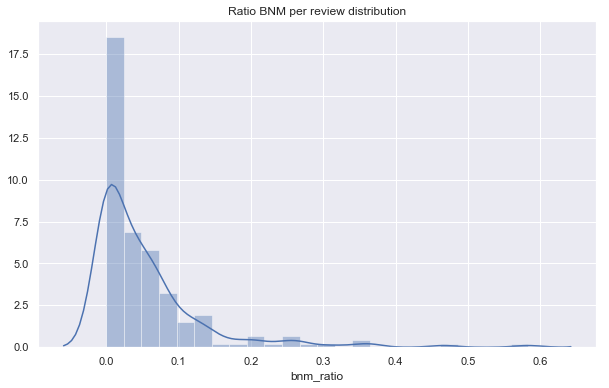

In [222]:
plt.figure(figsize=(10,6))

sns.distplot(filtered_authors_df['bnm_ratio'])

plt.title('Ratio BNM per review distribution');

In [219]:
# Get the 95% BNM ratio threshold
threshol_95 = filtered_authors_df['bnm_ratio'].quantile(.95)
threshol_95

0.21033081020465377

In [220]:
# Filter reviewer with BNM ratio > threshold
filtered_authors_df[filtered_authors_df['bnm_ratio'] >= threshol_95].sort_values('bnm_ratio', ascending=False)

,author,bnm_count,review_count,bnm_ratio
315,ryan schreiber,7,12,0.583333
196,kris ex,7,15,0.466667
347,stephen thomas erlewine,4,11,0.363636
30,anupa mistry,5,14,0.357143
152,jeff weiss,5,16,0.312500
153,jenn pelly,11,41,0.268293
163,jillian mapes,4,15,0.266667
47,brent dicrescenzo,4,16,0.250000
264,ned raggett,6,24,0.250000
361,tom ewing,9,41,0.219512


## Conclusion

As seen in the first part, we can say that BNM albums are significantly rated differently to the other albums. We can also say that few reviewers (10) have an abnormally high BNM ratio (> 95% quantile)